In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import tqdm
import pickle
import matplotlib
import numpy as np
import pandas as pd
import ase.io as aio
from ase import Atoms
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from toolz.curried import pipe, curry, compose

import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [4]:
import atom_stat as astat

In [5]:
import utilities as utils

In [6]:
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())

In [7]:
runs = np.loadtxt("runs.txt").astype(int)
runs.shape

(77,)

In [8]:
def get_atom_subset(coords, 
                    c_min=np.array([-181.5]*3), 
                    r_stat=30, 
                    cell=np.array([362.95089012]*3)):
    
    x_bot = np.array([1.,1.,1.]) * r_stat
    x_top = cell - x_bot

    c_list = []
    for c in coords:
        if np.all((c - c_min) > x_bot) and np.all((c - c_min) < x_top):
            c_list.append(c[None])
            
    return np.concatenate(c_list, axis=0)

### When computing for damaged structures, atoms corresponding to the damaged region are considered.

In [39]:
%%time
ix=0

atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
             lambda f: utils.load_file(f))

# atoms = pipe("structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
#              lambda f: utils.load_file(f), 
#              get_atoms)

# indexes = np.where(atoms.get_tags() != 1)[0]


indexes = np.random.randint(0, len(atoms), 50000)

print("No. of disturbed atoms: {}".format(len(indexes)))

coords_all = atoms.get_positions()
coords_sub = coords_all[indexes]

print(atoms.get_cell())

No. of disturbed atoms: 50000
Cell([362.950890120128, 362.950890120128, 362.950890120128])
CPU times: user 244 ms, sys: 135 ms, total: 379 ms
Wall time: 213 ms


### Compute RDF

## $X(r) = \dfrac{n\left(r\right)}{\dfrac{4}{3}\pi(r_1^3 - r_0^3)n_0}$

In [41]:
r_stat=15
len_pixel=50
nbins=(r_stat + 2) * len_pixel + 1
bins=np.linspace(0.0, r_stat + 2, nbins)[1:]

In [42]:
%%time
coords_sub_in = get_atom_subset(coords_sub)

CPU times: user 342 ms, sys: 56 µs, total: 342 ms
Wall time: 342 ms


In [43]:
%%time
rdf, pdf = astat.get_rdf_tree(coords_all, coords_sub_in, cutoff=r_stat, nbins=nbins)

CPU times: user 17.1 s, sys: 648 ms, total: 17.7 s
Wall time: 17.7 s


In [44]:
pdf_0 = pdf.copy()

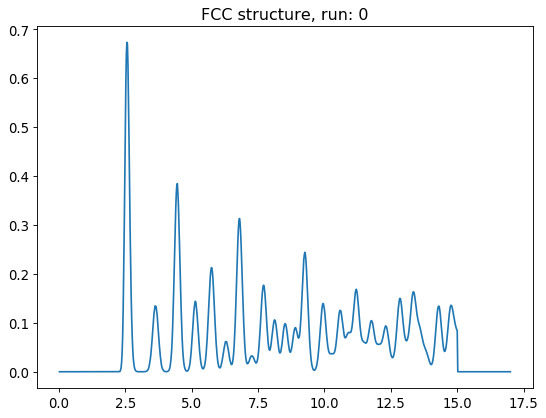

In [45]:
bins = np.linspace(0.0, r_stat+2, nbins)[1:]
plt.plot(bins, pdf)
plt.title("FCC structure, run: {}".format(runs[ix]))
plt.show()

### Visualize

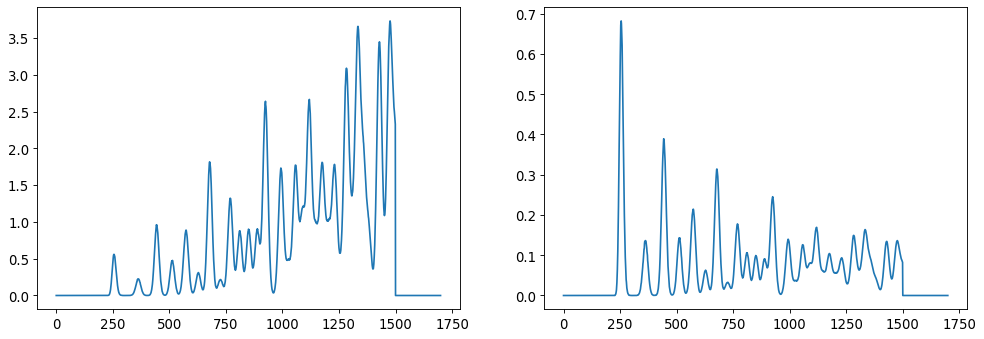

In [17]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))
ax[0].plot(rdf)
ax[1].plot(pdf[0:])
plt.show()

## Smoothening Protocol

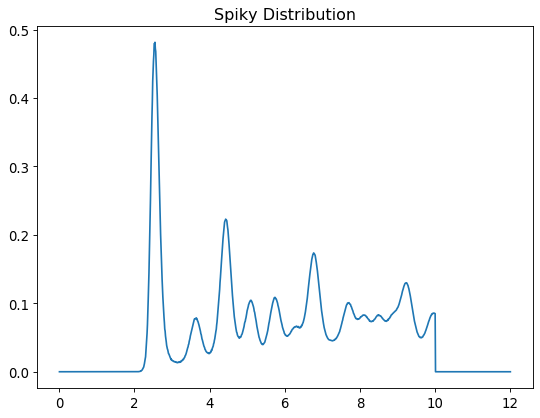

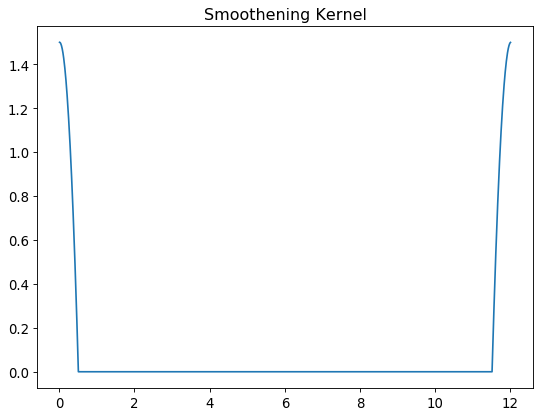

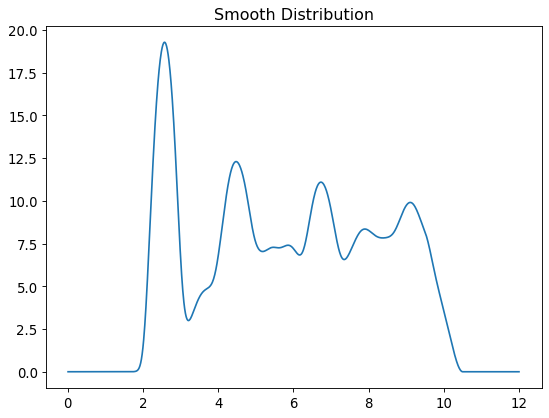

0.9849029999999996
68.61215823405847


In [33]:
bins = np.linspace(0.0, r_stat+2, nbins)[1:]

plt.plot(bins, pdf)
plt.title("Spiky Distribution")
plt.show()

kernel = astat.epanechnikov_kernel(width=0.5, x=bins)

plt.plot(bins, kernel)
plt.title("Smoothening Kernel")
plt.show()

new_pdf = astat.convolve_kernel(kernel, pdf)

plt.plot(bins, new_pdf)
plt.title("Smooth Distribution")
plt.show()

print(np.trapz(kernel, bins))
print(np.trapz(new_pdf, bins))

## Analysis over all structures

In [28]:
folder_pdf = "data/pdfs"
if not os.path.exists(folder_pdf):
    os.mkdir(folder_pdf)

In [29]:
r_stat=15
len_pixel=50
nbins=(r_stat + 2) * len_pixel + 1
bins=np.linspace(0.0, r_stat + 2, nbins)[1:]
kernel=astat.epanechnikov_kernel(width=0.5, x=bins)

In [30]:
def generate_rdf(run, r_stat=r_stat, nbins=nbins):
    
    print(run)
    atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(run), 
                 lambda f: utils.load_file(f))
    
    indxs = np.where(atoms.get_tags() != 1)[0]

    coords_all = atoms.get_positions()
    coords_sub = coords_all[indxs]
    
    pdf = []
    if len(indxs) != 0:
        coords_sub_in = get_atom_subset(coords_sub, 
                                        c_min=np.array([-181.5]*3), 
                                        r_stat=30, 
                                        cell=np.array([362.95089012]*3))
        
        pdf = astat.get_rdf_tree(coords_all, coords_sub_in, cutoff=r_stat, nbins=nbins)[-1]
        utils.save_file(fname="{}/dump.arc.{}_pdf.pkl".format(folder_pdf, run), obj=pdf)

In [ ]:
# p_spiky = []
# vols = []
# n_atoms_all = []
# n_atoms_irr = []
# n_atoms_irr_sub = []

# for run in tqdm.tqdm_notebook(runs):

#     atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(run), 
#                  lambda f: utils.load_file(f))
    
#     indxs = np.where(atoms.get_tags() != 1)[0]

#     coords_all = atoms.get_positions()
#     coords_sub = coords_all[indxs]
    
    
#     n_atoms_all.append(len(coords_all))
#     n_atoms_irr.append(len(coords_sub))

#     if len(indxs) != 0:
        
#         n_atoms_irr_sub.append(len(coords_sub_in))
#         coords_sub_in = get_atom_subset(coords_sub)
#         rdf, pdf = astat.get_rdf_tree(coords_all, coords_sub_in, cutoff=r_stat, nbins=nbins)
#         p_spiky.append(pdf)

In [ ]:
# save_file("data/cu_rdf_spiky_periodic.pkl", p_spiky)
# utils.save_file("data/tot_atom_count.pkl", n_atoms_all)
# utils.save_file("data/irr_atom_count.pkl", n_atoms_irr)
# utils.save_file("data/irr_atom_subset_count.pkl", n_atoms_irr_sub)

In [47]:
# save_file("cu_rdf_spiky_01.pkl", p_spiky)

In [36]:
run = runs[1]
f_pdf = "{}/dump.arc.{}_pdf.pkl".format(folder_pdf, run)
pdf = utils.load_file(f_pdf)

In [51]:
p_spiky = []
p_spiky.append(pdf_0)

for run in runs[1:]:
    f_pdf = "{}/dump.arc.{}_pdf.pkl".format(folder_pdf, run)
    pdf = utils.load_file(f_pdf)
    p_spiky.append(pdf)

## Analysis of RDF signals

In [56]:
kernel = astat.epanechnikov_kernel(width=0.25, x=bins)
p_smooth_0 = []
for pdf in p_spiky:
    new_pdf = astat.convolve_kernel(kernel, pdf)
    p_smooth_0.append(new_pdf)

kernel = astat.epanechnikov_kernel(width=0.5, x=bins)
p_smooth = []
for pdf in p_spiky:
    new_pdf = astat.convolve_kernel(kernel, pdf)
    p_smooth.append(new_pdf)
    
kernel = astat.epanechnikov_kernel(width=1.0, x=bins)
p_smooth_1 = []
for pdf in p_spiky:
    new_pdf = astat.convolve_kernel(kernel, pdf)
    p_smooth_1.append(new_pdf)

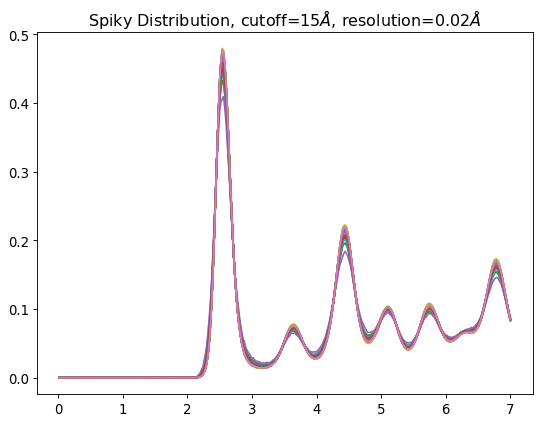

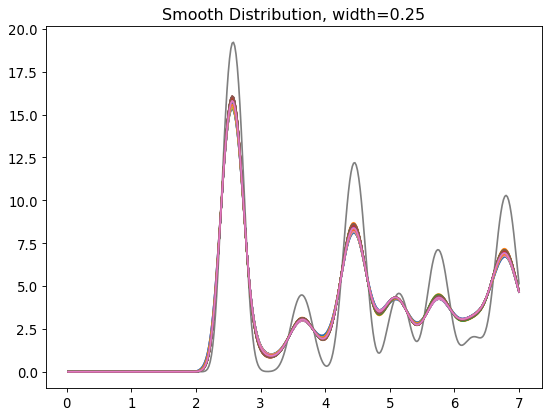

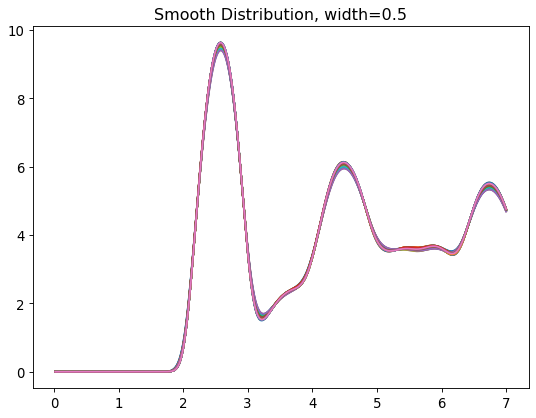

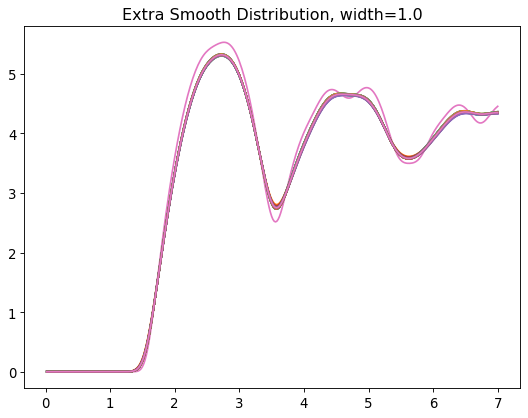

In [58]:
ix = 500
n_samples = 77
for i in np.random.randint(0, len(p_spiky), n_samples):
    plt.plot(bins[:-ix], p_spiky[i][:-ix])
plt.title("Spiky Distribution, cutoff={}$\AA$, resolution={}$\AA$".format(r_stat, 1/len_pixel))
plt.show()


for i in np.random.randint(0, len(p_spiky), n_samples):
    plt.plot(bins[:-ix], p_smooth_0[i][:-ix])
plt.title("Smooth Distribution, width=0.25")
plt.show()


for i in np.random.randint(0, len(p_spiky), n_samples):
    plt.plot(bins[:-ix], p_smooth[i][:-ix])
plt.title("Smooth Distribution, width=0.5")
plt.show()

for i in np.random.randint(0, len(p_spiky), n_samples):
    plt.plot(bins[:-ix], p_smooth_1[i][:-ix])
plt.title("Extra Smooth Distribution, width=1.0")
plt.show()

In [98]:
## RDF signlas containing NANs identified
indxs = np.where(np.any(np.isnan(p_smooth)==False, axis=1))[0]
print(len(indxs))

n_atoms_irr = utils.load_file("data/scalers_irr_atom_count.pkl")
df = pd.read_csv("scalers_all.csv", index_col=0)

77


## Correlation with RDF

(77, 841)
[9.55621852e-01 3.31513360e-02 7.27320941e-03 2.22073234e-03
 8.29286953e-04 3.78000077e-04 1.35955000e-04 9.90484116e-05
 4.90519906e-05 4.27776508e-05]


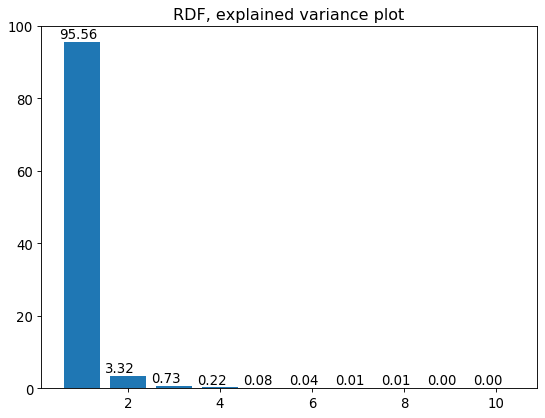

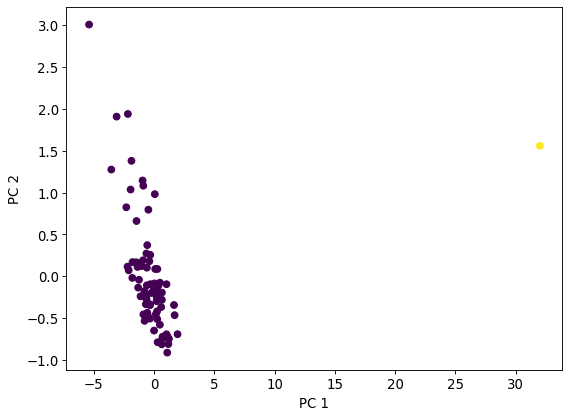

In [116]:
x_data = np.concatenate([item[None] for item in p_smooth_0], axis=0)


x_data = x_data[indxs][:,:-ix]
print(x_data.shape)

pca = PCA(n_components=10)
scores = pca.fit_transform(x_data)
print(pca.explained_variance_ratio_)

ex_var = pca.explained_variance_ratio_ * 100
plt.bar(np.arange(1, 11), ex_var)
plt.ylim([0, 100])
for ix, item in enumerate(ex_var):
    plt.text(ix+0.5, item+1.0, "{:1.2f}".format(item))
plt.title("RDF, explained variance plot")
plt.show()


label = [1] * len(scores)
label[0] = 10
plt.scatter(scores[:,0], scores[:,1], c=label)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

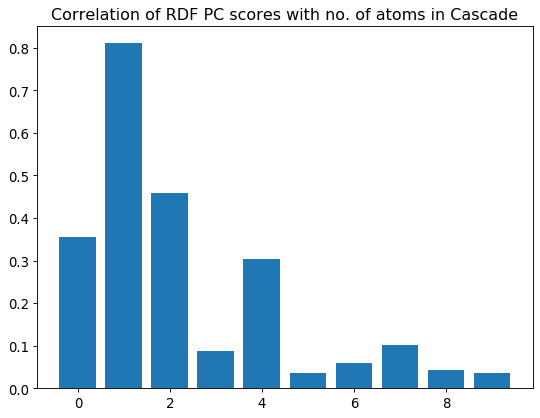

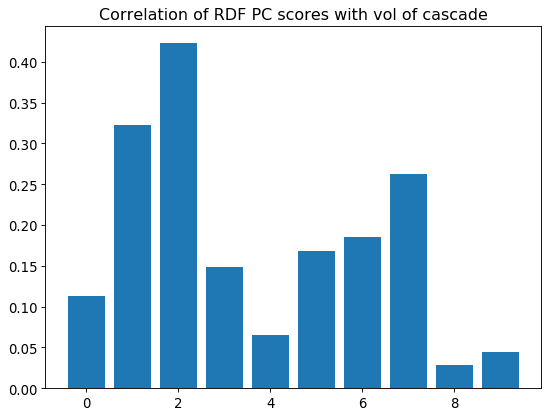

In [105]:
corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores[1:,ix], df["n_atoms_irr"])[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of RDF PC scores with no. of atoms in Cascade")
plt.show()


corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores[1:,ix], df["vol"])[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of RDF PC scores with vol of cascade")
plt.show()


## Correlation with SAED

In [95]:
img_saed_list = utils.load_file("data/saed_masked_imgs.pkl")
img_saed = np.concatenate([np.ravel(im)[None] for im in img_saed_list], axis=0)

[0.85261128 0.03224536 0.01279692 0.01004065 0.00902789 0.00671244
 0.00651099 0.00585576 0.00485332 0.00419935]


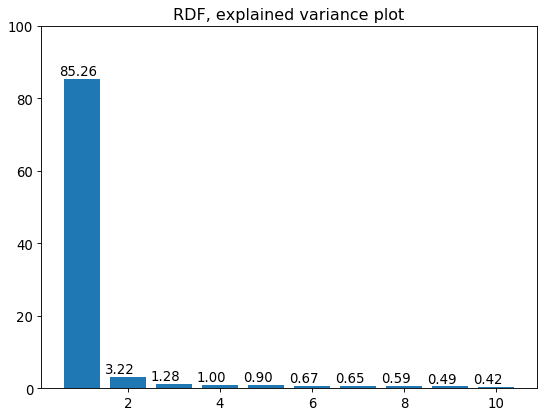

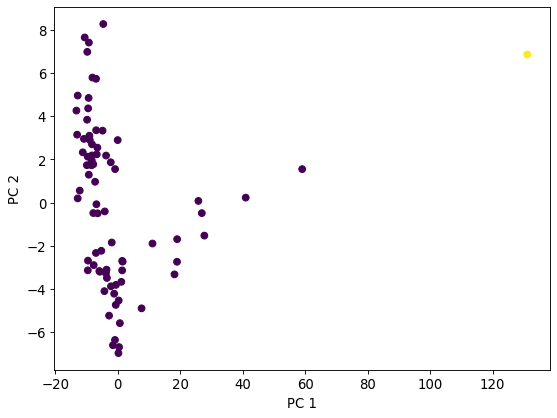

In [118]:
pca = PCA(n_components=10)
scores_saed = pca.fit_transform(img_saed)
print(pca.explained_variance_ratio_)

ex_var = pca.explained_variance_ratio_ * 100
plt.bar(np.arange(1, 11), ex_var)
plt.ylim([0, 100])
for ix, item in enumerate(ex_var):
    plt.text(ix+0.5, item+1.0, "{:1.2f}".format(item))
plt.title("RDF, explained variance plot")
plt.show()

label = [1] * len(scores)
label[0] = 10
plt.scatter(scores_saed[:,0], scores_saed[:,1], c=label)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

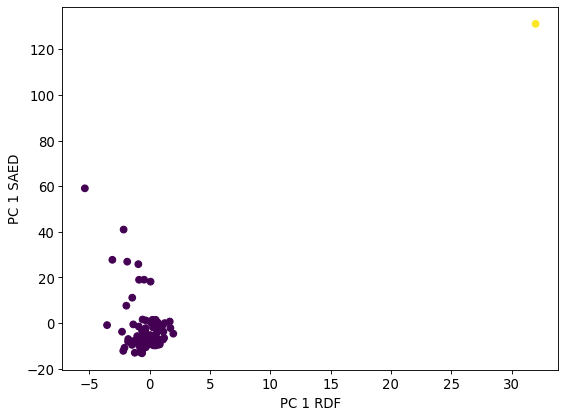

In [125]:
label = [1] * len(scores)
label[0] = 10
plt.scatter(scores[:,0], scores_saed[:,0], c=label)
plt.xlabel("PC 1 RDF")
plt.ylabel("PC 1 SAED")
plt.show()

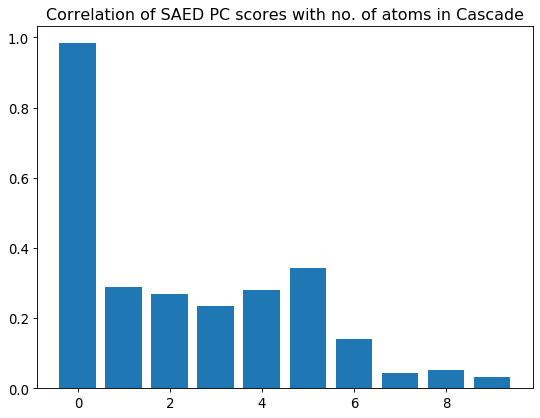

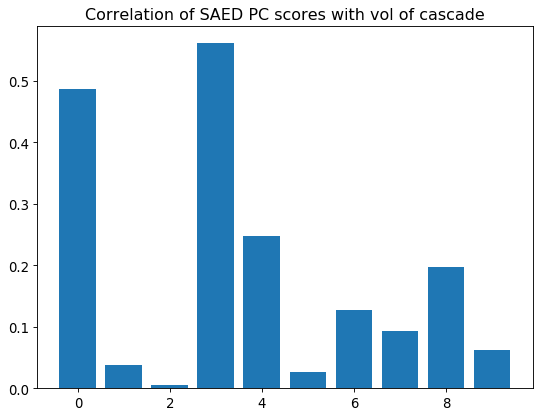

In [137]:
corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores_saed[1:,ix], df["n_atoms_irr"])[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of SAED PC scores with no. of atoms in Cascade")
plt.show()


corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores_saed[1:,ix], df["m2_x"])[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of SAED PC scores with vol of cascade")
plt.show()

## Between SAED and RDF

In [131]:
n_samples = 5
dmat = np.zeros([n_samples, n_samples])


for ix in range(n_samples):
    for iy in range(n_samples):
        dmat[ix, iy] = np.fabs(np.corrcoef(scores[:,ix], scores_saed[:,iy])[0,1])

In [132]:
dmat

array([[0.64475077, 0.22810874, 0.20488812, 0.34452239, 0.26300098],
       [0.71255278, 0.29168041, 0.15245197, 0.35256252, 0.1631946 ],
       [0.12556138, 0.18867139, 0.18593047, 0.03209016, 0.33761261],
       [0.14678613, 0.5308252 , 0.01434838, 0.12456451, 0.08083009],
       [0.09281637, 0.03596268, 0.15316123, 0.15386499, 0.28337567]])

In [130]:
dmat

array([[0.44603123, 0.0991281 , 0.06544232, 0.42335579, 0.10343348],
       [0.84728401, 0.36231758, 0.21121236, 0.43314   , 0.23805932],
       [0.38696108, 0.16250611, 0.16134436, 0.00232387, 0.31362742],
       [0.132051  , 0.52706107, 0.03097062, 0.14741022, 0.10427768],
       [0.23556386, 0.05240733, 0.1420778 , 0.17536056, 0.31132971]])

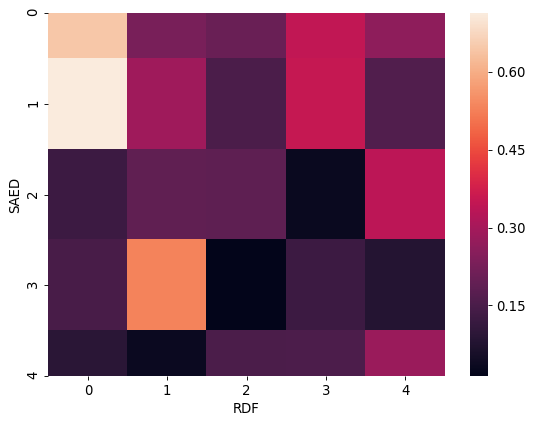

In [138]:
sns.heatmap(dmat)
plt.xlabel("RDF")
plt.ylabel("SAED")
plt.show()